# Recreating Zwift ride powerplot

## Import .fit file and convert to pandas dataframe

The code for importing .fit files and converting to a pandas dataframe is from http://johannesjacob.com/analyze-your-cycling-data-python/.
To install the python packages, type 'pip install pandas numpy fitparse matplotlib tqdm' on the command line.


In [1]:
import os
import datetime
from fitparse import FitFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from smooth import smooth
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox, AnchoredText, AnchoredOffsetbox)
from matplotlib.text import Annotation


In [3]:
filename = input("Type filename, including .fit extension:  ")
# 2021-10-05-10-54-32.fit

fitfile = FitFile(filename)

Type filename, including .fit extension:  2021-10-05-10-54-32.fit


From Johannes Jacob's blog post:  
_"Now we are ready to import the workout file and transform the data into a 
pandas dataframe. Unfortunately we have to use an ugly hack with this "while" 
loop to avoid timing issues. Then we are looping through the file, append 
the records to a list and convert the list to a pandas dataframe."_

In [4]:
while True:
    try:
        fitfile.messages
        break
    except KeyError:
        continue
workout = []
for record in fitfile.get_messages('record'):
    r = {}
    for record_data in record:
        r[record_data.name] = record_data.value
    workout.append(r)
df = pd.DataFrame(workout)

In [5]:
df

,altitude,cadence,compressed_speed_distance,cycle_length,distance,enhanced_altitude,enhanced_speed,grade,heart_rate,position_lat,position_long,power,resistance,speed,temperature,time_from_course,timestamp
0,5.0,108,None,None,None,5.0,9.948,None,165,-138819701,1991832102,280,None,9.948,None,None,2021-10-05 18:05:18
1,5.0,109,None,None,None,5.0,10.150,None,166,-138820063,1991831076,248,None,10.150,None,None,2021-10-05 18:05:19
2,5.0,110,None,None,None,5.0,10.311,None,167,-138820372,1991830018,245,None,10.311,None,None,2021-10-05 18:05:20
3,5.0,108,None,None,None,5.0,10.464,None,168,-138820865,1991828979,248,None,10.464,None,None,2021-10-05 18:05:21
4,4.8,107,None,None,None,4.8,10.771,None,168,-138821057,1991827881,234,None,10.771,None,None,2021-10-05 18:05:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4671,-5.4,0,None,None,None,-5.4,1.061,None,143,-138956810,1991928451,0,None,1.061,None,None,2021-10-05 19:23:09
4672,-5.4,0,None,None,None,-5.4,0.330,None,142,-138956881,1991928423,0,None,0.330,None,None,2021-10-05 19:23:10
4673,-5.4,0,None,None,None,-5.4,0.000,None,142,-138956889,1991928420,0,None,0.000,None,None,2021-10-05 19:23:11
4674,-5.4,0,None,None,None,-5.4,0.000,None,141,-138956888,1991928421,0,None,0.000,None,None,2021-10-05 19:23:12


In [6]:
df.tail(1)

,altitude,cadence,compressed_speed_distance,cycle_length,distance,enhanced_altitude,enhanced_speed,grade,heart_rate,position_lat,position_long,power,resistance,speed,temperature,time_from_course,timestamp
4675,-5.4,0,None,None,None,-5.4,0.0,None,141,-138956888,1991928421,0,None,0.0,None,None,2021-10-05 19:23:13


## Get date of workout from column 'timestamp' 

In [7]:
timestamp = df['timestamp'].tail(1).values
timestamp

array(['2021-10-05T19:23:13.000000000'], dtype='datetime64[ns]')

In [8]:
date = np.datetime_as_string(timestamp, unit='D')
date

array(['2021-10-05'], dtype='<U28')

In [9]:
date_str = str(date)
type(date_str)
print(date_str)


['2021-10-05']


In [10]:
date_str = date_str.strip("[")
date_str = date_str.strip("]")
date_str = date_str.strip("'")
print(date_str)

2021-10-05


##  Remove unnecessary columns

In [11]:
df.columns

Index(['altitude', 'cadence', 'compressed_speed_distance', 'cycle_length',
       'distance', 'enhanced_altitude', 'enhanced_speed', 'grade',
       'heart_rate', 'position_lat', 'position_long', 'power', 'resistance',
       'speed', 'temperature', 'time_from_course', 'timestamp'],
      dtype='object')

I'd like to keep the following columns only:
* cadence
* heart_rate
* power
* speed


In [12]:
df_subset = pd.DataFrame(df, columns=['cadence', 'heart_rate', 'power', 'speed'])
df_subset

,cadence,heart_rate,power,speed
0,108,165,280,9.948
1,109,166,248,10.150
2,110,167,245,10.311
3,108,168,248,10.464
4,107,168,234,10.771
...,...,...,...,...
4671,0,143,0,1.061
4672,0,142,0,0.330
4673,0,142,0,0.000
4674,0,141,0,0.000


In [13]:
df_subset['power'].isna().value_counts()

False    4676
Name: power, dtype: int64

In [14]:
len(df_subset)

4676

##  Insert a column 'time_unit' 

_**Note:  Zwift records workout data once every second.  Using .fit files with data recorded more or less frequently will result in an incorrect number of minutes on the x-axis of the graph.**_

In [15]:
df_subset.insert(loc=0, column='time_unit', value=np.arange(len(df_subset)))

In [16]:
df_subset

,time_unit,cadence,heart_rate,power,speed
0,0,108,165,280,9.948
1,1,109,166,248,10.150
2,2,110,167,245,10.311
3,3,108,168,248,10.464
4,4,107,168,234,10.771
...,...,...,...,...,...
4671,4671,0,143,0,1.061
4672,4672,0,142,0,0.330
4673,4673,0,142,0,0.000
4674,4674,0,141,0,0.000


In [17]:
df_subset.rename(columns = {'power':'watts'}, inplace = True)

In [18]:
df_subset

,time_unit,cadence,heart_rate,watts,speed
0,0,108,165,280,9.948
1,1,109,166,248,10.150
2,2,110,167,245,10.311
3,3,108,168,248,10.464
4,4,107,168,234,10.771
...,...,...,...,...,...
4671,4671,0,143,0,1.061
4672,4672,0,142,0,0.330
4673,4673,0,142,0,0.000
4674,4674,0,141,0,0.000


In [50]:
df_subset['watts'].max()

294

In [59]:
max_w_t = df_subset['time_unit'].loc[df_subset['watts'] == df_subset['watts'].max()]
max_w_t

2134    2134
Name: time_unit, dtype: int64

In [20]:
df_subset.loc[df_subset['watts'] == "NaN"]

,time_unit,cadence,heart_rate,watts,speed


In [21]:
df_subset['watts'].fillna(0, inplace=True)

##  Obtain FTP value from user to determine workout zones in graph

In [22]:
ftp = None

# set up try / except loop:
n = 0
while n < 3: 
    try:
        ftp = int(input("Enter FTP in watts (whole numbers only):  "))
        print(f"\nYour FTP has been recorded as {ftp} watts.")
        break
    except ValueError:
        n += 1
        print("\nYour FTP value cannot contain letters, be left blank, or be entered as a decimal value. \n")


Enter FTP in watts (whole numbers only):  126

Your FTP has been recorded as 126 watts.


In [23]:
# convert df to numpy array

workout_data = df_subset.to_records(index=False)

In [24]:
workout_data

rec.array([(   0, 108, 165, 280,  9.948), (   1, 109, 166, 248, 10.15 ),
           (   2, 110, 167, 245, 10.311), ...,
           (4673,   0, 142,   0,  0.   ), (4674,   0, 141,   0,  0.   ),
           (4675,   0, 141,   0,  0.   )],
          dtype=[('time_unit', '<i8'), ('cadence', '<i8'), ('heart_rate', '<i8'), ('watts', '<i8'), ('speed', '<f8')])

In [68]:
cadence = workout_data['cadence']
HR = workout_data['heart_rate']

In [69]:
cadence

array([108, 109, 110, ...,   0,   0,   0])

In [70]:
HR

array([165, 166, 167, ..., 142, 141, 141])

In [25]:
watts = workout_data['watts']
time = workout_data['time_unit']

In [71]:
workout_data['watts'].max()

294

In [26]:
watts

array([280, 248, 245, ...,   0,   0,   0])

In [61]:
max_watts = max(watts)
max_watts

294

In [28]:
y_top = max(watts)*1.05
y_top

308.7

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(time, watts)
plt.plot(max_watts, 'r+')
plt.annotate(f'Max power: {max_watts}', max_watts, xytext=(0, 20), arrowprops={}, textcoords='offset points');

In [29]:
watts_smoothed = smooth(watts, window_len=20)
print(len(watts_smoothed))
watts_smoothed

4676


array([280.        , 268.64838868, 257.4518006 , ...,   0.        ,
         0.        ,   0.        ])

##  Give user the opportunity to enter how often .fit file data is recorded, in seconds (default is once per second, as on Zwift)

In [30]:
# Workout .fit file recorded by Zwift?

zwift_or_not = input("Was your .fit file recorded by Zwift, and/or did you device record the workout in 1-second increments?  \nEnter 'y' for yes or 'n' for no. ")

Was your .fit file recorded by Zwift, and/or did you device record the workout in 1-second increments?  
Enter 'y' for yes or 'n' for no. 


In [31]:
zwift_or_not

''

In [32]:
if zwift_or_not=='y' or zwift_or_not=='':
    rec_freq = 1
    print(f"\nThe default recording frequency has been set to {rec_freq} second.")

    
# If .fit file not recorded by Zwift, how frequently was data recorded, in seconds?

if zwift_or_not=='n':
    # default recording frequency to start with:
    rec_freq = 1
    
    # set up try / except loop:
    n = 0
    while n < 3: 
        try:
            rec_freq = int(input("Please enter the frequency that your workout data was recorded, in seconds.  \nEntry must be in numbers >0 and <=60, e.g., '1' for once per second, '5' to represent data recorded once every 5 seconds, '10' to signify once every 10 seconds, etc.   "))
            print(f"\nThe recording frequency has been set to {rec_freq} second(s).")
            break
        except ValueError:
            n += 1
            print()
        if n == 3:
            print(f"\nThe recording frequency has been set to {rec_freq} second(s).")



The default recording frequency has been set to 1 second.


In [33]:
rec_freq

1

##  Convert workout x-axis time values to minutes

In [34]:
# converting recording data into minutes  
# freq represents how many rows of data are contained in 1 minute of workout time
# For example, if data is recorded every 5 seconds, then there will be 12 rows of data 
# per every one minute of workout time

freq = 60 / rec_freq
freq


60.0

In [103]:
minutes = workout_data['time_unit']/freq
print(minutes)
print(type(minutes))
print(minutes.dtype)

[0.00000000e+00 1.66666667e-02 3.33333333e-02 ... 7.78833333e+01
 7.79000000e+01 7.79166667e+01]
<class 'numpy.ndarray'>
float64


In [101]:
type(workout_data['watts'])

numpy.ndarray

In [102]:
workout_data['watts'].dtype

dtype('int64')

In [104]:
power = watts.astype('float64')

In [106]:
power.dtype

dtype('float64')

In [112]:
new_arr = np.stack([minutes, watts], axis=1)

In [116]:
new_arr

array([[0.00000000e+00, 2.80000000e+02],
       [1.66666667e-02, 2.48000000e+02],
       [3.33333333e-02, 2.45000000e+02],
       ...,
       [7.78833333e+01, 0.00000000e+00],
       [7.79000000e+01, 0.00000000e+00],
       [7.79166667e+01, 0.00000000e+00]])

In [117]:
new_arr.shape

(4676, 2)

In [118]:
workout_data

rec.array([(   0, 108, 165, 280,  9.948), (   1, 109, 166, 248, 10.15 ),
           (   2, 110, 167, 245, 10.311), ...,
           (4673,   0, 142,   0,  0.   ), (4674,   0, 141,   0,  0.   ),
           (4675,   0, 141,   0,  0.   )],
          dtype=[('time_unit', '<i8'), ('cadence', '<i8'), ('heart_rate', '<i8'), ('watts', '<i8'), ('speed', '<f8')])

## Find time where max power occurred

In [93]:
max_watts_index = np.argmax(workout_data['watts'])  # returns index of first occurrence of max_watts
max_watts_index

2134

In [95]:
workout_data[2134]

(2134, 102, 163, 294, 8.722)

In [94]:
max_watts_t = np.where(workout_data['watts'].max())
max_watts_t

(array([0]),)

## Graph workout

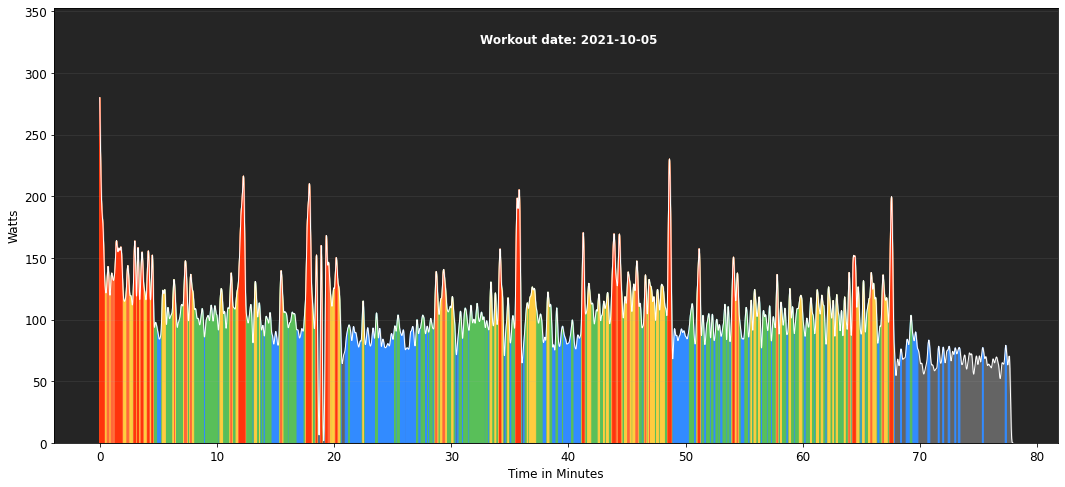

In [36]:
if ftp != None:
    figsize = (18, 8)    
    img, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor(color='#252525')
    ax.set_xlabel("Time in Minutes", fontsize='large')
    ax.set_ylabel("Watts", fontsize='large')
    ax.tick_params(labelsize='large')

    # This expands the top of the graph to 20% beyond max watts
    ax.set_ylim(top=max(watts)*1.20)

    # logic for color under the graph based on % of FTP (thanks to Jonas Häggqvist for this code)
    ax.grid(which='major', axis='y', alpha=0.1, linewidth=1)
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 0.00*ftp, color='#646464')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 0.60*ftp, color='#328bff')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 0.75*ftp, color='#59bf59')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 0.90*ftp, color='#ffcc3f')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 1.05*ftp, color='#ff663a')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 1.18*ftp, color='#ff340c')

    # Setting the image and location (thanks to Phil Daws for the code that helped me get started)
    # Note:  xy for the purposes of workout date label is set using 'data' for coordinates 
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xy = [xmax-(xmax*0.05), ymax-(ymax*0.05)]
    
    # Adding the workout date to the graph
    workout_date = Annotation(f'Workout date: {date_str}', xy=[xmax//2, ymax-(ymax*0.08)], 
                              ha='center', color='white', fontweight='bold', fontsize='large')
    ax.add_artist(workout_date)
    
    # Annotating max power
    max_watts_point = Annotation(f'Max power: {max_watts}', xy=[])
    

    # Setting plot line color and thickness
    
    plt.plot(minutes, watts_smoothed, color='white', linewidth=1.0)

    plt.show()

else:
    print(f"\nThe graph cannot be drawn; no valid FTP was provided.")
    print(f"If you wish to try again, please have your FTP value ready and then reload this page.")
